# 0.0 Imports

## 0.1 Libraries

In [20]:
import pandas as pd
import numpy as np
import inflection
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from category_encoders import TargetEncoder

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## 0.2 Data

In [160]:
dados_sales = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/train.csv',low_memory=False)
dados_stores = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/store.csv')
dados = pd.merge(dados_sales,dados_stores,how='left',on='Store')
dados = dados.sample(int(round(dados.shape[0]/5,0)),random_state=101) # Reduce the size of the dataset in 10 (Too big)
dados.reset_index(drop=True,inplace=True)
dados.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,965,7,2014-11-02,0,0,0,0,0,0,a,c,110.0,NaN,NaN,0,NaN,NaN,NaN
1,268,1,2013-12-30,6995,814,1,0,0,1,a,a,4520.0,2.0,2014.0,0,NaN,NaN,NaN
2,1112,6,2015-03-28,8671,774,1,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
3,128,1,2014-07-21,6675,534,1,0,0,0,d,c,2000.0,NaN,NaN,1,1.0,2013.0,"Jan,Apr,Jul,Oct"
4,687,4,2015-06-11,6961,675,1,0,0,0,d,c,2770.0,NaN,NaN,0,NaN,NaN,NaN


## 0.3 Helper Functions

# 1.0 Data Description and Cleaning

## 1.1 Rename Columns and Values

In [161]:
# CamelCase to snake_case
for c in range(len(dados.columns)):
    dados.rename(columns={dados.columns.values[c]:inflection.underscore(dados.columns.values[c])},inplace=True)

In [162]:
dados['state_holiday'] = dados['state_holiday'].map({'a':'public holiday', 'b':'Easter holiday', 'c':'Christmas', '0':'None'})
dados['assortment'] = dados['assortment'].map({'a':'basic','b':'extra','c':'extended'})

## 1.2 Data Dimension

In [163]:
print(f'Rows: {dados.shape[0]}\nColumns: {dados.shape[1]}')

Rows: 339070
Columns: 18


## 1.3 Data Types

### 1.3.1 Check

In [164]:
dados.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

### 1.3.2 Change

In [165]:
# date to datetime64
dados['date'] = pd.to_datetime(dados['date'])

## 1.4 NaN

### 1.4.1 Check

In [166]:
dados.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance               895
competition_open_since_month    108121
competition_open_since_year     108121
promo2                               0
promo2_since_week               169365
promo2_since_year               169365
promo_interval                  169365
dtype: int64

### 1.4.2 Dealing With

In [167]:
## competition_distance, competition_open_since_month, competition_open_since_year

# I suppose that the competition_distance == nan refers that there's no competition!
# Lets'se if it's true

dados[dados['competition_distance'].isna()].isna().sum()

store                             0
day_of_week                       0
date                              0
sales                             0
customers                         0
open                              0
promo                             0
state_holiday                     0
school_holiday                    0
store_type                        0
assortment                        0
competition_distance            895
competition_open_since_month    895
competition_open_since_year     895
promo2                            0
promo2_since_week               636
promo2_since_year               636
promo_interval                  636
dtype: int64

Yeah, thats true. 

All of the empty distances have empty competition_open_since.. what confirm that the competition has never been started! 

In [168]:
for index in dados[dados['competition_distance'].isna()].index:
    dados.loc[index,'competition_distance'] = 999999 # High values suggests that the competitors are so far that there's no competition
    dados.loc[index,'competition_open_since_month'] = 0 # It suggets that it has never been opened
    dados.loc[index,'competition_open_since_year'] = 0 # It suggets that it has never been opened

In [169]:
## competition_open_since_month, competition_open_since_year

# I suppose that if there's no year, there's no month and vice-versa
# Let's se if it's true

dados[dados['competition_open_since_month'].isna()].isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month    107226
competition_open_since_year     107226
promo2                               0
promo2_since_week                45629
promo2_since_year                45629
promo_interval                   45629
dtype: int64

Yeah, 100% true!

Then, i suppose that we do not have these dates by some reason

In [170]:
month_median = round(dados['competition_open_since_month'].median(),0)
year_median = round(dados['competition_open_since_year'].median(),0)
for index in dados[dados['competition_open_since_month'].isna()].index:
    dados.loc[index,'competition_open_since_month'] = month_median # Im gonna use median and round to have discret values
    dados.loc[index,'competition_open_since_year'] = year_median # Im gonna use median and round to have discret values

In [171]:
## promo_interval, promo2_since_week, promo2_since_year

# I wanna check if the NaN in these columns are just when promo2 is 0 (no promo2) what would be very logic.
# Because if there's no promo2, theres no since date or interval

(dados[dados['promo2']==0].isna()).sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance                 0
competition_open_since_month         0
competition_open_since_year          0
promo2                               0
promo2_since_week               169365
promo2_since_year               169365
promo_interval                  169365
dtype: int64

So true! 

Every NaN in the last 3 columns is because promo2 has never been started!

In [172]:
for index in dados[dados['promo2_since_week'].isna()].index:
    dados.loc[index, 'promo2_since_week'] = 0 # It suggets that there's no promo2 week start
    dados.loc[index, 'promo2_since_year'] = 0 # It suggets that there's no promo2 year start
    dados.loc[index, 'promo_interval'] = 'No promo2' # For now, im going to substitute with this

KeyboardInterrupt: 

### 1.4.3 Final Check

In [ ]:
dados.isna().sum()

## 1.5 Data Types (after NaN)

### 1.5.1 Check

In [ ]:
dados.dtypes

### 1.5.2 Change

In [ ]:
# float to int in columns related to dates
dados['competition_open_since_month'] = dados['competition_open_since_month'].astype(int)
dados['competition_open_since_year'] = dados['competition_open_since_year'].astype(int)
dados['promo2_since_week'] = dados['promo2_since_week'].astype(int)
dados['promo2_since_year'] = dados['promo2_since_year'].astype(int)

## 1.6 Descriptive Statistics

### 1.6.1 Separate Categorical and Numeric Variables

In [ ]:
dados

In [ ]:
dados_num = dados[['store','day_of_week','sales','customers','competition_distance','competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year']]
dados_cat = dados.drop(['store','day_of_week','sales','customers','competition_distance','competition_open_since_month','competition_open_since_year','promo2_since_week','promo2_since_year','date'],axis=1)

### 1.6.2 Numeric Variables Analysis

In [ ]:
# Distribution in numbers

num_kurt = dados_num.apply(lambda x: x.kurtosis()) # Add kurtosis
num_skew = dados_num.apply(lambda x: x.skew()) # Add skew
num_range = dados_num.apply(lambda x: x.max() - x.min()) # Add range
pd.concat([dados_num.describe().T,num_kurt,num_skew,num_range],axis=1).rename(columns={0:'kurtosis',1:'skew',2:'range'}).drop('count',1)

Nothing strange.

The only strange values that we see were the ones that we chose arbitraly to substitute.

### 1.6.3 Categorical Variables Analysis

In [ ]:
for column in dados_cat.columns.values:
    print(column.upper()+':')
    print(round(dados_cat[column].value_counts(normalize=True)*100,2))
    print('')

Everything looks nice.

## 1.7 Columns and Values Filtering

In [ ]:
# Let's filter what is useful and useless for our prediction based on the business demand
dados.drop('customers',axis=1,inplace=True) # We can't predict using this, because we don't have this answer to input
dados = dados[dados['open']==1] # We want to predict sales when the store is open. When it's closed, sales == 0
dados.drop('open',axis=1,inplace=True) # This column would be constant == 1, useless for our prediction

## Exporting Dataset (After Data Cleaning)

In [ ]:
dados.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_cleaned.csv',index=False)

# 2.0 Exploratory Data Analysis

## Import Data

In [174]:
dados = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_cleaned.csv')

## 2.1 Hyphotesis

**DATE**

**1 -** As lojas vendem mais no começo do mês do que no final

**2 -** Houve um crescimento de vendas ao longo dos anos

**3 -** Lojas vendem mais no fim de semana

**4 -** Lojas vendem mais em feriados

**5 -** Lojas vendem mais no segundo semestre

**6 -** Lojas vendem mais no 3º trimestre.

**7 -** Lojas vendem mais no verão

**COMPETITION**

**8 -** Se a loja tem competidor ela vende menos

**9 -** Quanto mais velha é a competição, menos a loja vende

**10 -** Quanto mais longe é o competidor, mais vende a loja

**STORE**

**11 -** Existem tipos de loja que vendem substancialmente mais

**12 -** Quanto mais diversa é a loja, mais ela vende

**PROMOTIONS**

**13 -** Quando tem promoção as lojas vendem mais

**14 -** Quanto mais vezes se tem promoção em um período, menos eficaz ela fica

**15 -** Quanto mais vezes se tem promoção em um período, mais a loja vende

**16 -** Se a loja acatar a promo2 ela vende mais

**17 -** Existem períodos onde a promo2 é mais eficaz em relação às vendas

**18 -** Quanto mais antiga a promo2, menos a loja vende

## 2.2 Feature Engineering

In [ ]:
# Day, Month, Week and Year Variables
dados['day'] = pd.to_datetime(dados['date']).dt.day
dados['month'] = pd.to_datetime(dados['date']).dt.month
dados['year'] = pd.to_datetime(dados['date']).dt.year
dados['week'] = pd.to_datetime(dados['date']).dt.week

In [ ]:
# Semester and Quarter
dados['quarter'] = pd.to_datetime(dados['date']).dt.quarter
dados['semester'] = pd.to_datetime(dados['date']).dt.quarter.apply(lambda x: 1 if x == 1 or x == 2 else 2)

In [ ]:
# Season
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'

dados['season'] = pd.to_datetime(dados['date']).map(season_of_date)

In [ ]:
# Weeks for timeseries analyses
dados['week_bin'] = np.nan
for index in range(dados.shape[0]):
    if dados.loc[index,'year']==2013:
        dados.loc[index,'week_bin'] = dados.loc[index,'week']
    if dados.loc[index,'year']==2014:
        dados.loc[index,'week_bin'] = dados.loc[index,'week'] + 52
    if dados.loc[index,'year']==2015:
        dados.loc[index,'week_bin'] = dados.loc[index,'week'] + 104
dados['week_bin'] = dados['week_bin'].astype('int')

In [ ]:
# Competition Lifetime
dados['competition_lifetime'] = np.nan
for index in range(dados.shape[0]):
    try:
        data = datetime.datetime(dados.loc[index,'competition_open_since_year'],dados.loc[index,'competition_open_since_month'],1)
        dados.loc[index, 'competition_lifetime'] = (pd.to_datetime(dados.loc[index,'date']) - data).days
        
    except:
        dados.loc[index,'competition_lifetime'] = -999 # Never opened
dados['competition_lifetime'] = dados['competition_lifetime'].astype('int')

In [ ]:
# Competition
dados['competition'] = dados['competition_lifetime'].apply(lambda x: 0 if x<0 else 1) 

# Negative values suggests that this competition has never been started yet or we don't even have competitors (we chose -999 above)

In [ ]:
# Promo2 Lifetime
dados['promo2_lifetime'] = np.nan
for index in range(dados.shape[0]):
    if dados.loc[index,'promo_interval'] != 'No promo2':
        year = dados.loc[index,'promo2_since_year']
        week = dados.loc[index,'promo2_since_week']
        date = "{}-W{}".format(year,week)
        date_datetime = datetime.datetime.strptime(date + '-1', "%Y-W%W-%w")
        dados.loc[index,'promo2_lifetime'] = (pd.to_datetime(dados.loc[index,'date']) - date_datetime).days
    else:
        dados.loc[index,'promo2_lifetime'] = -999
dados['promo2_lifetime'] = dados['promo2_lifetime'].astype(int)

In [ ]:
# Promo Count per Week
dados['promo_count_per_week'] = np.nan
for index in range(dados.shape[0]):
    week = dados.loc[index,'week_bin']
    store = dados.loc[index,'store']
    try:
        dados.loc[index,'promo_count_per_week'] = dados[dados['store']==store].groupby('week_bin').sum()['promo'][week]
    except:
        dados.loc[index,'promo_count_per_week'] = 0
dados['promo_count_per_week'] = dados['promo_count_per_week'].astype('int')

In [ ]:
# Enumerate per week each store promotion
dados['promo_n'] = np.nan
for c in range(dados.shape[0]):
    if dados.loc[c,'promo_count_per_week']>0: # os que tem promoção na semana: Enumerate the promotion per store on each week
        week = dados.loc[c,'week_bin']
        store = dados.loc[c,'store']
        df_aux = pd.DataFrame(dados[(dados['store']==store)&(dados['week_bin']==week)].sort_values(by='date')['promo'])[dados['promo']==1].reset_index().reset_index().set_index('index')
        df_aux['level_0'] = df_aux['level_0'] + 1
        for index in df_aux.index:
            dados.loc[index,'promo_n'] = df_aux.loc[index,'level_0']
    elif dados.loc[c,'promo_count_per_week']==0: # os que não tem promoção na semana: iguala a 0
        dados.loc[c,'promo_n'] = 0
dados['promo_n'].fillna(-1,inplace=True) # São dias sem promoção em semanas com promoção: iguala a -1
dados['promo_n'] = dados['promo_n'].astype('int')

## Exporting Dataset (After Feature Engineering)

In [ ]:
dados.to_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_feature_engineering.csv',index=False)

## Import Data

In [2]:
dados = pd.read_csv('/Users/nando/Comunidade DS/ds_em_producao/data/data_feature_engineering.csv')

## 2.3 Univariate Analysis

### 2.3.1 Dependent Variable

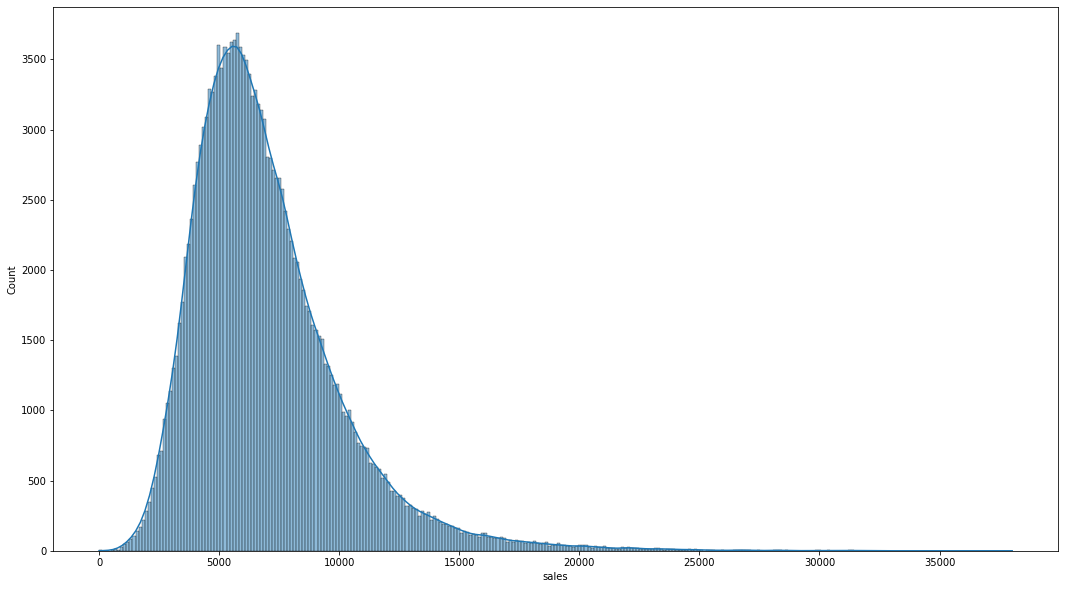

In [3]:
# Distribution Graph

plt.figure(figsize=(18,10))
sns.histplot(dados['sales'],kde=True);

In [4]:
# Descriptive Analysis

desc_dep = pd.DataFrame(dados['sales'].describe()).T
desc_dep['kurtosis'] = dados['sales'].kurtosis() # Add kurtosis
desc_dep['skew'] = dados['sales'].skew() # Add skew
desc_dep['range'] = dados['sales'].max() - dados['sales'].min() # Add range
desc_dep

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew,range
sales,168974.0,6952.024844,3101.494039,0.0,4860.0,6366.5,8360.0,38025.0,4.976669,1.609256,38025


Not a normal distribution, but very close to it.

Mean and Median almost the same (6300-6900 sales). But has a little skew and kurtosis not equal 3.

It's what i was expecting, positive skewness distribution. (Sales has this behavior)

### 2.3.2 Independent Variables

In [5]:
# Store, Day of Week, State Holiday, School Holiday, Store Type and Assortment

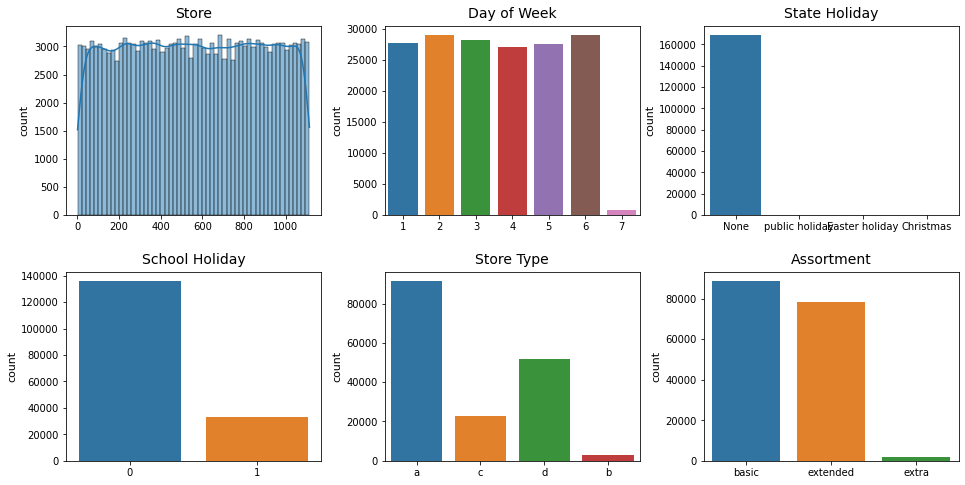

In [6]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(hspace=0.3,wspace=0.25)

plt.subplot(2,3,1)
ax = sns.histplot(dados['store'],kde=True)
ax.set_title('Store',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(2,3,2)
ax = sns.countplot(dados['day_of_week'])
ax.set_title('Day of Week',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(2,3,3)
ax = sns.countplot(dados['state_holiday'])
ax.set_title('State Holiday',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(2,3,4)
ax = sns.countplot(dados['school_holiday'])
ax.set_title('School Holiday',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(2,3,5)
ax = sns.countplot(dados['store_type'])
ax.set_title('Store Type',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(2,3,6)
ax = sns.countplot(dados['assortment'])
ax.set_title('Assortment',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)


plt.show()

What we can observe:

**Store:** We can consider that we have the same represatition for all stores

**Day of Week:** In sunday it has way less represantation (Probably because the stores are closed this day)

**State Holiday and School Holiday:** Seems to behave as expected, more normal days and less holidays. 

**Store Type:** There's a visible predominance of some store types.

**Assortment:** more assortment == less representation

In [7]:
# competition, competition_distance, competition_lifetime, competition_open_since_month and competition_open_since_year

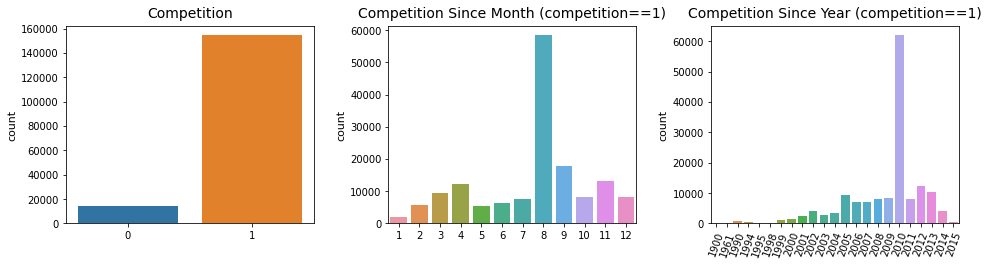

In [8]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,3,1)
ax = sns.countplot(dados['competition'])
ax.set_title('Competition',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(2,3,2)
ax = sns.countplot(dados[dados['competition']==1]['competition_open_since_month'])
ax.set_title('Competition Since Month (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(2,3,3)
ax = sns.countplot(dados[dados['competition']==1]['competition_open_since_year'])
ax.set_title('Competition Since Year (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)
plt.tick_params(axis='x',rotation=70)

plt.show()

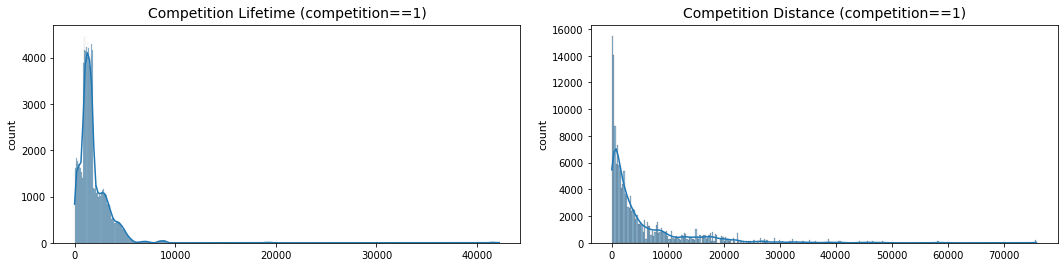

In [9]:
plt.figure(figsize=(18,4))
plt.subplots_adjust(wspace=0.15)
plt.subplot(1,2,1)
ax = sns.histplot(dados[dados['competition']==1]['competition_lifetime'],kde=True)
ax.set_title('Competition Lifetime (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(1,2,2)
ax = sns.histplot(dados[dados['competition']==1]['competition_distance'],kde=True)
ax.set_title('Competition Distance (competition==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.show()

What we can observe:

**Competition:** We can see that almost every records are from stores with competition that already started

**Competition Distance:** Competitors are usually close to the stores. The distribution has a positive skew, what is expected for this kind of feature.

**Competition Lifetime:** The competition is recent in most cases. The distribution has a positive skew, what is expected for this kind of feature.

**Competition Open Since Month:** We have a peak of competition start in august for some reason, which probably is a interesting insight.

**Competition Open Since Year:** We have a peak again, now in 2010 for some reason, which also might be an insight. Beyond that, this features shows in detail what i observed in Competition Lifetime: Most of competitors are very recent (10-15 years).

In [10]:
# promo, promo_count_per_week, promo_n, promo2, promo2_since_week, promo2_since_year, promo2_interval, promo2_lifetime

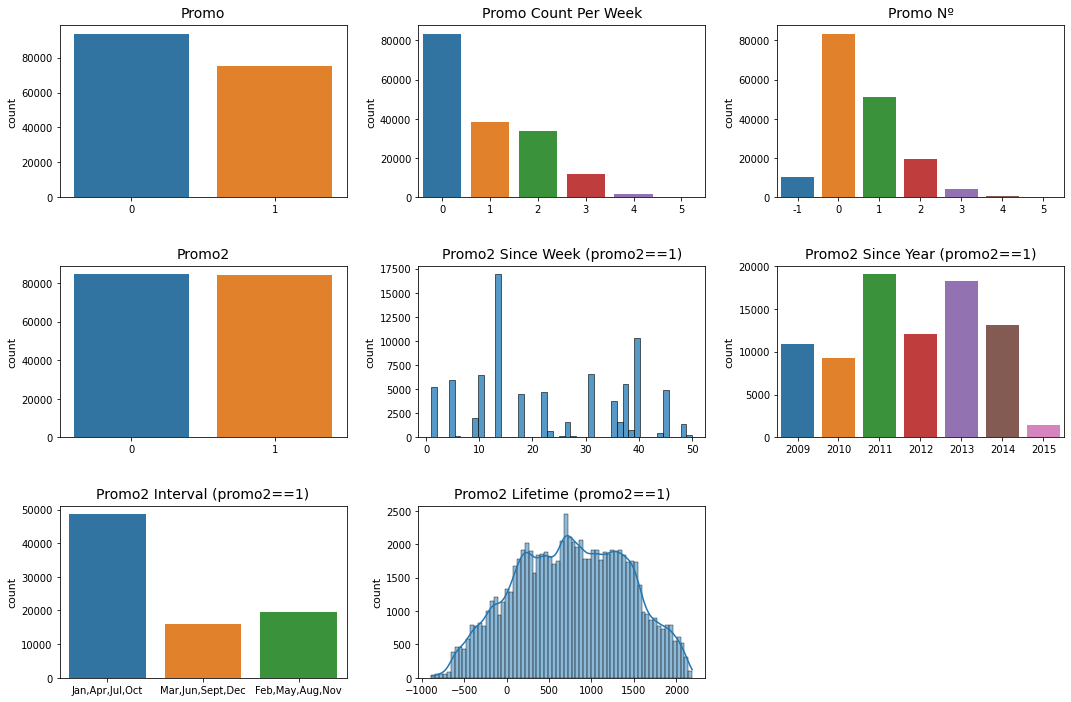

In [11]:
plt.figure(figsize=(18,12))
plt.subplots_adjust(hspace=0.4,wspace=0.25)

plt.subplot(3,3,1)
ax = sns.countplot(dados['promo'])
ax.set_title('Promo',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,2)
ax = sns.countplot(dados['promo_count_per_week'])
ax.set_title('Promo Count Per Week',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,3)
ax = sns.countplot(dados['promo_n'])
ax.set_title('Promo Nº',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,4)
ax = sns.countplot(dados['promo2'])
ax.set_title('Promo2',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,5)
ax = sns.histplot(dados[dados['promo2']==1]['promo2_since_week'])
ax.set_title('Promo2 Since Week (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,6)
ax = sns.countplot(dados[dados['promo2']==1]['promo2_since_year'])
ax.set_title('Promo2 Since Year (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,7)
ax = sns.countplot(dados[dados['promo2']==1]['promo_interval'])
ax.set_title('Promo2 Interval (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,8)
ax = sns.histplot(dados[dados['promo2']==1]['promo2_lifetime'],kde=True)
ax.set_title('Promo2 Lifetime (promo2==1)',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)


plt.show()

What we can observe:

**Promo:** There's a huge represantation of promo, which means that almost every day we have promo

**Promo Count Per Week:** It's what i expected, a descendant barplot

**Promo Nº:** As expected, follows the same behavior of promo count per week, a lot of 0 and 1, a descendant barplot.

**Promo2:** Around a half of the stores adopted promo2

**Promo2 Since Week:** We have some periods with high and other with almost no acceptance. There must have a good reason for it.

**Promo2 Since Year:** We can observe that 2011 was a important year for the promo2, because the representation, if not greater, it's almost the same, never less. We need to observe that 2015 has way less contribution compared to other years, probably because this data doesn't include the whole year of 2015.

**Promo2 Interval:** We have a visible difference between the interval adopted, there's one that is chosen most times and others with similar acceptance.

**Promo2 Lifetime:** Most of the records are with promo2 already running. We clearly see that most of these records are from promo2 which started no more than 1500 days ago (after that we have a notorious drop), what shows that since 2011 (1500 days) there's a higher adoption of promo2, what already has been observed on Promo2 Since Year.

In [12]:
# day, month, year, week, quarter, semester and season

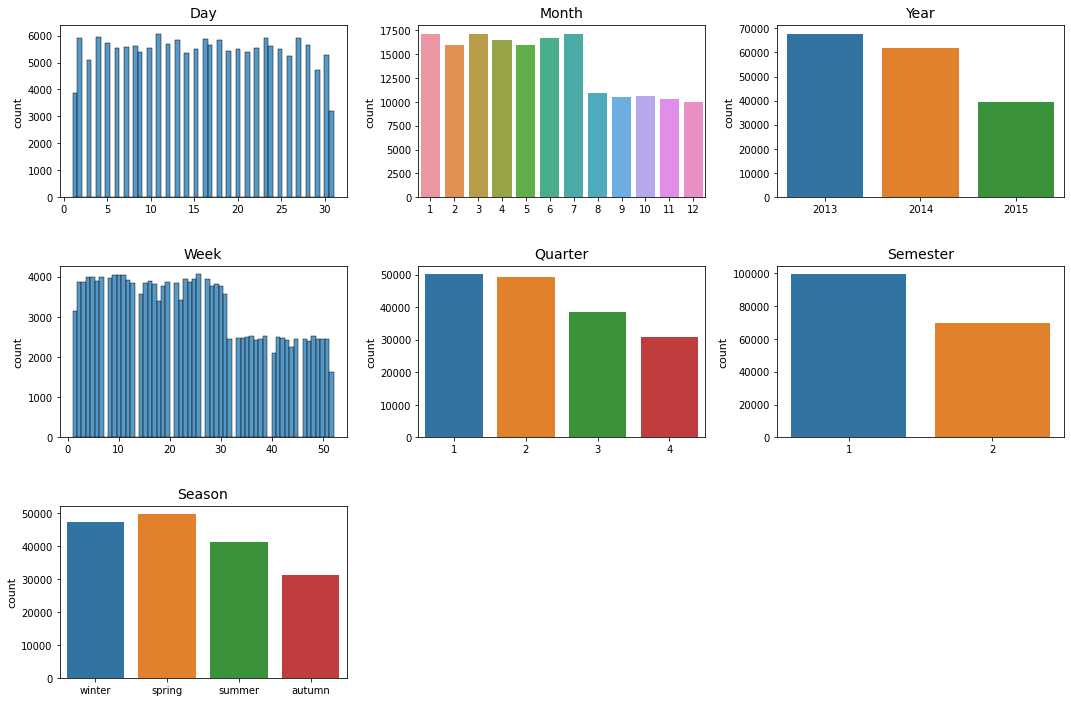

In [13]:
plt.figure(figsize=(18,12))
plt.subplots_adjust(hspace=0.4,wspace=0.25)

plt.subplot(3,3,1)
ax = sns.histplot(dados['day'])
ax.set_title('Day',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,2)
ax = sns.countplot(dados['month'])
ax.set_title('Month',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,3)
ax = sns.countplot(dados['year'])
ax.set_title('Year',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,4)
ax = sns.histplot(dados['week'])
ax.set_title('Week',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,5)
ax = sns.countplot(dados['quarter'])
ax.set_title('Quarter',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,6)
ax = sns.countplot(dados['semester'])
ax.set_title('Semester',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)

plt.subplot(3,3,7)
ax = sns.countplot(dados['season'])
ax.set_title('Season',size=14,pad=8)
ax.set_xlabel('')
ax.set_ylabel('count',size=11)


plt.show()

What we can observe:

**Day:** We have a similar representation between values, but the first and the last that of the month we have less records for some reason.

**Month:** Most of the records are from the first semester, probably because 2015 is not completed yet i suppose.

**Year:** As we talked all time, 2015 has less records. But 2014 has less than 2013 for some reason.

**Week:** We have less representation of the second semester, but there're peak in this variable for some reason

**Quarter:** The first semester have equal distribution between it's quarters, the other one doesn't.

**Semester:** As already observed, less representation of the second semester.

**Season:** Not have a equal distribution, because of the semesters representation difference

We can conclude that the time is not very well distributed, we have a clear difference of representation in a lot of features!

## 2.4 Bivariate Analysis

In [394]:
# Day of Week

### H1: As lojas vendem mais no começo do mês do que no final

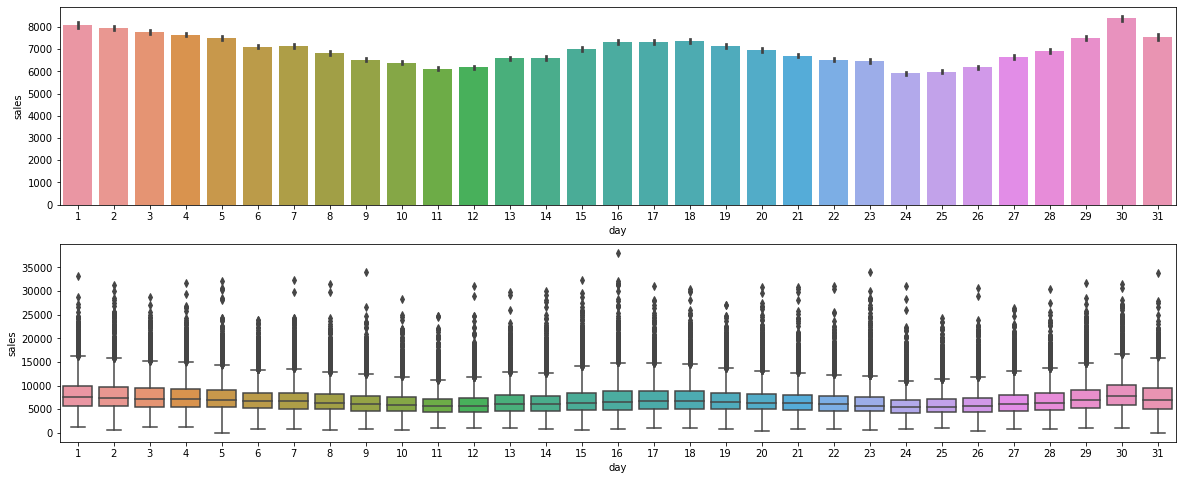

In [14]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
sns.barplot(x=dados['day'],y=dados['sales'])
plt.subplot(2,1,2)
sns.boxplot(x=dados['day'],y=dados['sales'])
plt.show()

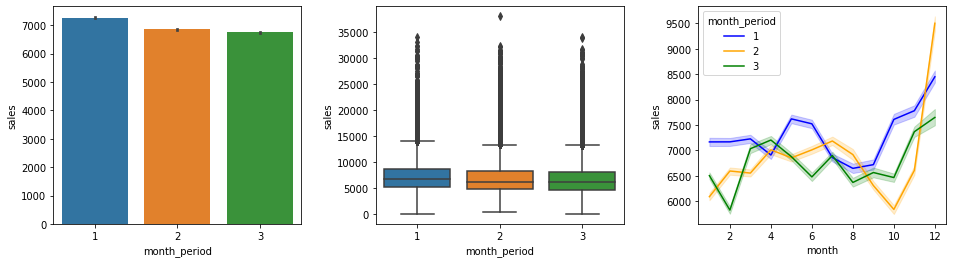

In [15]:
# 1 == 10 first days, 2 == 10 middle days, 3 == 10* (* == or 11) ending days
month_period = dados['day'].apply(lambda x: 1 if x<=10 else (2 if 20>=x>=11 else 3)) 

plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
ax = sns.barplot(x=month_period,y=dados['sales'])
ax.set_xlabel('month_period')

plt.subplot(1,3,2)
ax = sns.boxplot(x=month_period,y=dados['sales'])
ax.set_xlabel('month_period')

plt.subplot(1,3,3)
ax = sns.lineplot(x=dados['month'],y=dados['sales'],hue=month_period,palette=['blue','orange','green'])
ax.legend(title='month_period')
plt.show()

The hypotheis is **TRUE**

The difference of store sales between days/month_period are highly impacted by the period of the year, as we can see in the last graph.

However if we analyse sales on whole year, there's a little difference between days/month_period.

### H2: Houve um crescimento de vendas ao longo dos anos

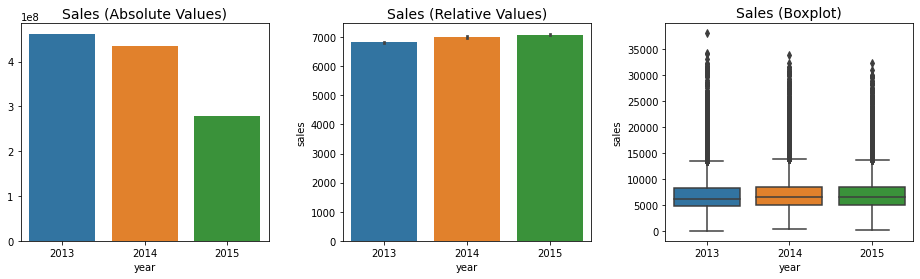

In [16]:
plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
ax = sns.barplot(x=dados.groupby('year').sum()['sales'].index,y=dados.groupby('year').sum()['sales'].values)
ax.set_title('Sales (Absolute Values)',size=14)

plt.subplot(1,3,2)
ax = sns.barplot(x=dados['year'],y=dados['sales'])
ax.set_title('Sales (Relative Values)',size=14)

plt.subplot(1,3,3)
ax = sns.boxplot(x=dados['year'],y=dados['sales'])
ax.set_title('Sales (Boxplot)',size=14)

plt.show()

The hypothesis ask for a absolute value analyses, but as we saw on the univariate analysis, these classes are not well balanced.

In [17]:
# Tradicional Descriptive Analysis of sales over the years
dados.groupby('year').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,67771.0,6817.858553,3126.440146,0.0,4716.0,6207.0,8196.0,38025.0
2014,61919.0,7012.757054,3116.122494,416.0,4900.0,6432.0,8446.5,33913.0
2015,39284.0,7087.757102,3025.404608,124.0,5047.0,6541.0,8504.0,32228.0


In [18]:
# Analysing the percentage of increasment over the years
round(dados.groupby('year').describe()['sales'].pct_change()*100,2)

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014,-8.63,2.86,-0.33,inf,3.9,3.62,3.06,-10.81
2015,-36.56,1.07,-2.91,-70.19,3.0,1.69,0.68,-4.97


The hypothesis is **TRUE**

We can clearly see a increasment on graph, mean and on 25%, 50%, 75%.

### H3: Lojas vendem mais no fim de semana

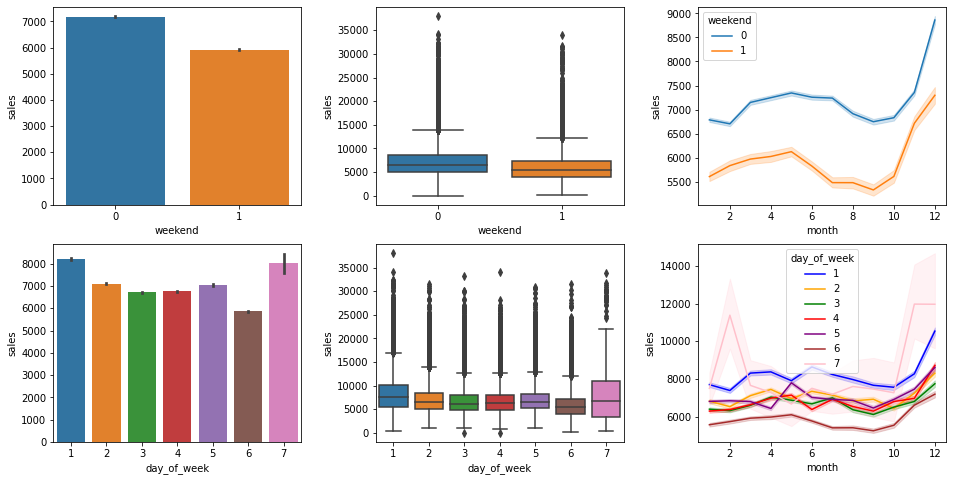

In [193]:
weekend = dados['day_of_week'].apply(lambda x: 1 if x==6 or x==7 else 0)

plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,3,1)
ax = sns.barplot(x=weekend,y=dados['sales'])
ax.set_xlabel('weekend')

plt.subplot(2,3,2)
ax = sns.boxplot(x=weekend,y=dados['sales'])
ax.set_xlabel('weekend')

plt.subplot(2,3,3)
ax = sns.lineplot(x=dados['month'],y=dados['sales'],hue=weekend)
ax.legend(title='weekend')

plt.subplot(2,3,4)
sns.barplot(x=dados['day_of_week'],y=dados['sales'])

plt.subplot(2,3,5)
sns.boxplot(x=dados['day_of_week'],y=dados['sales'])

plt.subplot(2,3,6)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['day_of_week'],palette=['blue','orange','green','red','purple','brown','pink'])

plt.show()

The hypothesis is **FALSE**

We can clearly see a high difference in the first 3 graphs, week days has way more sales all over the year.

In the last 3 graphs we can see that sunday is the best day of the week for sales. So, why we can claim that this hypothesis is false? We need to remember what we observed in univariate analysis: most of times stores doesn't even open on sunday's. So probably the stores only opens on especific sundays, which they know that it will be worth it. Then, we cannot say that weekends sells more using sunday as an example! 

### H4: Lojas vendem mais em feriados

In [194]:
# State holiday

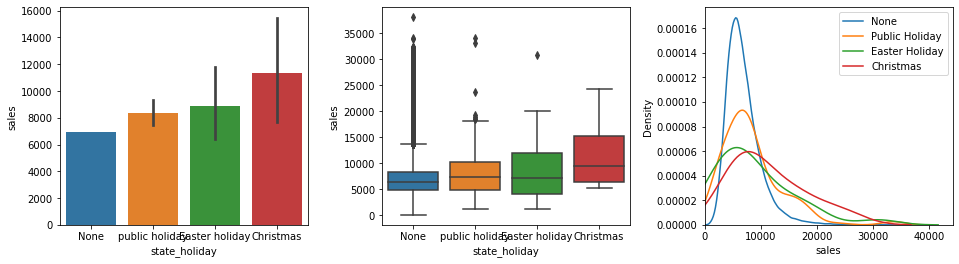

In [195]:
plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
sns.barplot(x=dados['state_holiday'],y=dados['sales'])

plt.subplot(1,3,2)
sns.boxplot(x=dados['state_holiday'],y=dados['sales'])

plt.subplot(1,3,3)
sns.kdeplot(dados[dados['state_holiday']=='None']['sales'])
sns.kdeplot(dados[dados['state_holiday']=='public holiday']['sales'])
sns.kdeplot(dados[dados['state_holiday']=='Easter holiday']['sales'])
sns.kdeplot(dados[dados['state_holiday']=='Christmas']['sales'])
plt.legend(['None','Public Holiday','Easter Holiday','Christmas'])
plt.xlim(dados['sales'].min())

plt.show()

In [196]:
# I want to analyse more accuractely the difference between easter, public holiday and normal days
dados.groupby('state_holiday').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
state_holiday,,,,,,,,
Christmas,9.0,11331.666667,6458.734861,5242.0,6421.0,9430.0,15117.00,24245.0
Easter holiday,27.0,8876.740741,6920.814634,1250.0,3977.0,7114.0,12001.50,30848.0
None,168790.0,6950.251194,3097.025048,0.0,4860.0,6366.0,8358.00,38025.0
public holiday,148.0,8357.364865,5409.142352,1147.0,4856.5,7402.0,10236.25,34133.0


For this feature the hypothesis is **TRUE**

We can see that christimas has way more sales than ever, it's a very lucrative holiday for the stores. However the other ones don't have this level of impact. 

There's a notorious incresement on sales on Public Holidays and in easter.

In [197]:
# School Holiday

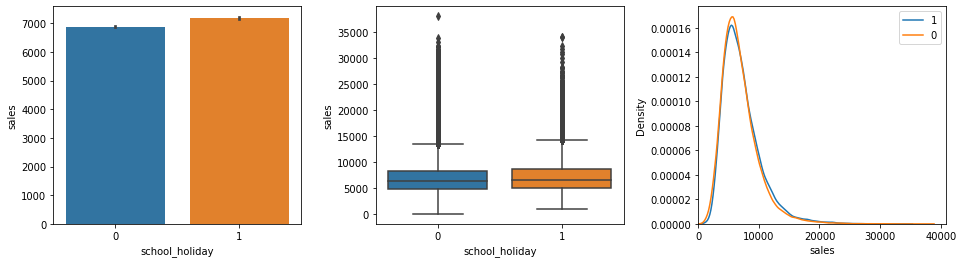

In [198]:
plt.figure(figsize=(16,4))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,3,1)
sns.barplot(x=dados['school_holiday'],y=dados['sales'])

plt.subplot(1,3,2)
sns.boxplot(x=dados['school_holiday'],y=dados['sales'])

plt.subplot(1,3,3)
sns.kdeplot(dados[dados['school_holiday']==1]['sales'])
sns.kdeplot(dados[dados['school_holiday']==0]['sales'])
plt.legend(['1','0'])
plt.xlim(dados['sales'].min())

plt.show()

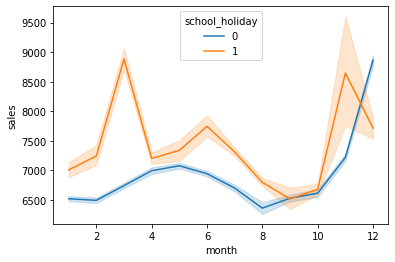

In [199]:
# Want to see if this 'no difference' between classes is present in the whole year
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['school_holiday']);

We need to investigate this different behavior, because at the first look the classes seems to have no impact on sales.

In [200]:
# Let's go deeper and analyse using descriptive analysis
df_aux = pd.DataFrame()
df_aux1 = dados[dados['school_holiday']==1].groupby('month').describe()['sales']
df_aux0 = dados[dados['school_holiday']==0].groupby('month').describe()['sales']
for column in df_aux1.columns.values:
    df_aux[f'{column} sc==0'] = df_aux0[column]
    df_aux[f'{column} sc==1'] = df_aux1[column]
    df_aux[f'{column} diff sc1 - sc0'] = df_aux[f'{column} sc==1']-df_aux[f'{column} sc==0']
    df_aux[f'{column} pct sc1/sc0'] = round(((df_aux[f'{column} sc==1']/df_aux[f'{column} sc==0'])-1)*100,2)
    df_aux[f'{column}'] = pd.Series([0,0,0,0,0,0,0,0,0,0,0,0,0])
df_aux

,count sc==0,count sc==1,count diff sc1 - sc0,count pct sc1/sc0,count,mean sc==0,mean sc==1,mean diff sc1 - sc0,mean pct sc1/sc0,mean,std sc==0,std sc==1,std diff sc1 - sc0,std pct sc1/sc0,std,min sc==0,min sc==1,min diff sc1 - sc0,min pct sc1/sc0,min,25% sc==0,25% sc==1,25% diff sc1 - sc0,25% pct sc1/sc0,25%,50% sc==0,50% sc==1,50% diff sc1 - sc0,50% pct sc1/sc0,50%,75% sc==0,75% sc==1,75% diff sc1 - sc0,75% pct sc1/sc0,75%,max sc==0,max sc==1,max diff sc1 - sc0,max pct sc1/sc0,max
month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14899.0,2227.0,-12672.0,-85.05,0,6519.518290,7006.862595,487.344306,7.48,0,2816.059047,2983.266680,167.207633,5.94,0,0.0,1198.0,1198.0,inf,0,4613.00,4991.50,378.50,8.21,0,6029.0,6426.0,397.0,6.58,0,7859.50,8405.50,546.00,6.95,0,32263.0,32228.0,-35.0,-0.11,0
2,14548.0,1384.0,-13164.0,-90.49,0,6492.128196,7242.730491,750.602295,11.56,0,2810.086002,3262.302220,452.216218,16.09,0,625.0,1641.0,1016.0,162.56,0,4617.00,5027.75,410.75,8.90,0,6028.5,6684.5,656.0,10.88,0,7790.00,8583.00,793.00,10.18,0,31448.0,31649.0,201.0,0.64,0
3,15659.0,1482.0,-14177.0,-90.54,0,6741.606808,8885.419703,2143.812896,31.80,0,2977.891935,3641.195352,663.303417,22.27,0,599.0,2141.0,1542.0,257.43,0,4741.00,6266.50,1525.50,32.18,0,6172.0,8305.5,2133.5,34.57,0,8096.00,10671.25,2575.25,31.81,0,28165.0,30729.0,2564.0,9.10,0
4,12514.0,4001.0,-8513.0,-68.03,0,6993.815007,7201.268183,207.453176,2.97,0,3118.830573,3149.850349,31.019777,0.99,0,416.0,1250.0,834.0,200.48,0,4851.50,4975.00,123.50,2.55,0,6414.5,6493.0,78.5,1.22,0,8496.00,8672.00,176.00,2.07,0,30848.0,29944.0,-904.0,-2.93,0
5,14777.0,1242.0,-13535.0,-91.60,0,7077.202680,7338.587762,261.385082,3.69,0,2953.281076,3226.165145,272.884069,9.24,0,923.0,2272.0,1349.0,146.15,0,5112.00,5117.25,5.25,0.10,0,6581.0,6737.5,156.5,2.38,0,8489.00,8752.50,263.50,3.10,0,33151.0,34133.0,982.0,2.96,0
6,15498.0,1176.0,-14322.0,-92.41,0,6943.552587,7745.228741,801.676154,11.55,0,3129.248048,3229.557069,100.309020,3.21,0,0.0,2409.0,2409.0,inf,0,4857.25,5472.75,615.50,12.67,0,6296.0,7070.5,774.5,12.30,0,8307.75,9319.00,1011.25,12.17,0,31477.0,27177.0,-4300.0,-13.66,0
7,9444.0,7719.0,-1725.0,-18.27,0,6699.277319,7311.012307,611.734988,9.13,0,2865.273620,3134.453509,269.179889,9.39,0,943.0,1143.0,200.0,21.21,0,4756.75,5095.00,338.25,7.11,0,6227.0,6724.0,497.0,7.98,0,8053.75,8829.00,775.25,9.63,0,30112.0,27508.0,-2604.0,-8.65,0
8,4126.0,6770.0,2644.0,64.08,0,6360.342705,6797.103250,436.760545,6.87,0,3164.460540,2781.390174,-383.070365,-12.11,0,316.0,1007.0,691.0,218.67,0,4309.00,4859.25,550.25,12.77,0,5802.5,6304.5,502.0,8.65,0,7703.25,8178.75,475.50,6.17,0,33913.0,23970.0,-9943.0,-29.32,0
9,9668.0,873.0,-8795.0,-90.97,0,6527.875052,6515.844215,-12.030836,-0.18,0,2840.517568,2779.255562,-61.262006,-2.16,0,740.0,1573.0,833.0,112.57,0,4623.00,4407.00,-216.00,-4.67,0,5961.0,6020.0,59.0,0.99,0,7824.25,7809.00,-15.25,-0.19,0,29777.0,21535.0,-8242.0,-27.68,0


For this feature the hypothesis **FALSE** 

We have to consider that at the first look we sae the same behavior between classes, no difference on store sales.

However we have to say that if we observe the behavior of the variable over the time, we can see that the classes have a huge dependence of which month we are looking at.

### H5: Lojas vendem mais no segundo semestre

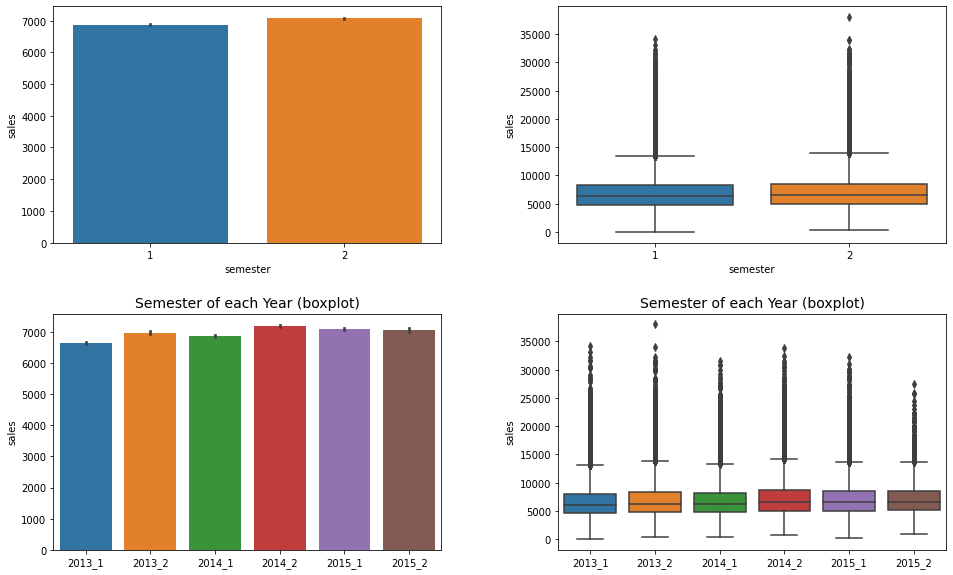

In [201]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.3,hspace=0.3)

plt.subplot(2,2,1)
sns.barplot(x=dados['semester'],y=dados['sales'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['semester'],y=dados['sales'])


# Let's see if this happens every year
plt.subplot(2,2,3)
year_semester = dados.apply(lambda x: str(x['year'])+'_'+str(x['semester']), axis=1)
ax = sns.barplot(x=year_semester,y=dados['sales'],order=['2013_1','2013_2','2014_1','2014_2','2015_1','2015_2'])
ax.set_title('Semester of each Year (boxplot)',size=14)

plt.subplot(2,2,4)
ax = sns.boxplot(x=year_semester,y=dados['sales'],order=['2013_1','2013_2','2014_1','2014_2','2015_1','2015_2'])
ax.set_title('Semester of each Year (boxplot)',size=14)

plt.show()

In [202]:
dados.groupby('semester').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
semester,,,,,,,,
1,99407.0,6867.643234,3019.250175,0.0,4826.0,6303.0,8256.0,34133.0
2,69567.0,7072.601018,3211.543569,316.0,4909.0,6463.0,8515.0,38025.0


The hypothesis is **TRUE**

As vendas são muito parecidas, mas em geral vemos um aumento nas vendas, acredito que 2015 não apresentou por não abranger todo o ano, especialmente o final, com datas comemorativas que já vimos puxar as vendas para cima!

### H6: Lojas vendem mais no 3º trimestre.

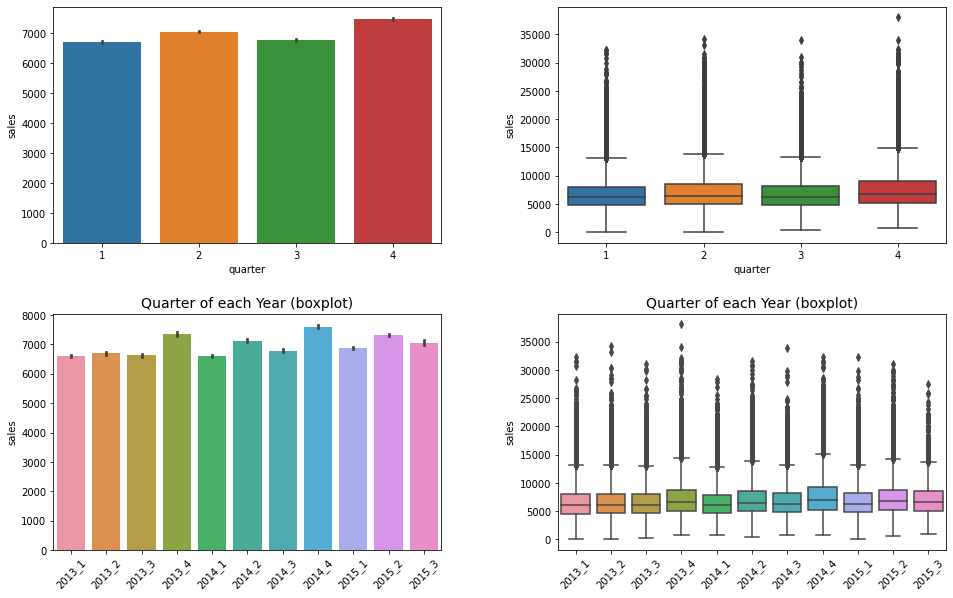

In [203]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.3,hspace=0.3)

plt.subplot(2,2,1)
sns.barplot(x=dados['quarter'],y=dados['sales'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['quarter'],y=dados['sales'])


# Let's see if this happens every year
plt.subplot(2,2,3)
year_quarter = dados.apply(lambda x: str(x['year'])+'_'+str(x['quarter']), axis=1)
ax = sns.barplot(x=year_quarter,y=dados['sales'], order = ['2013_1', '2013_2', '2013_3', '2013_4', '2014_1', '2014_2','2014_3', '2014_4', '2015_1', '2015_2', '2015_3'])
ax.set_title('Quarter of each Year (boxplot)',size=14)
plt.tick_params(axis='x',rotation=45)

plt.subplot(2,2,4)
ax = sns.boxplot(x=year_quarter,y=dados['sales'], order = ['2013_1', '2013_2', '2013_3', '2013_4', '2014_1', '2014_2','2014_3', '2014_4', '2015_1', '2015_2', '2015_3'])
ax.set_title('Quarter of each Year (boxplot)',size=14)
plt.tick_params(axis='x',rotation=45)

plt.show()

The hypothesis is **FALSE**

Podemos ver que em geral, ao menos em 2013 e 2014 (pois 2015 não existe registro), o último trimestre é onde há maior número de vendas.

O terceiro trimestre geralmente vende até menos que o segundo, e parecido com o primeiro, o que corrobora ainda mais com a conclusão da hipótese 5.

### H7: Lojas vendem mais no verão

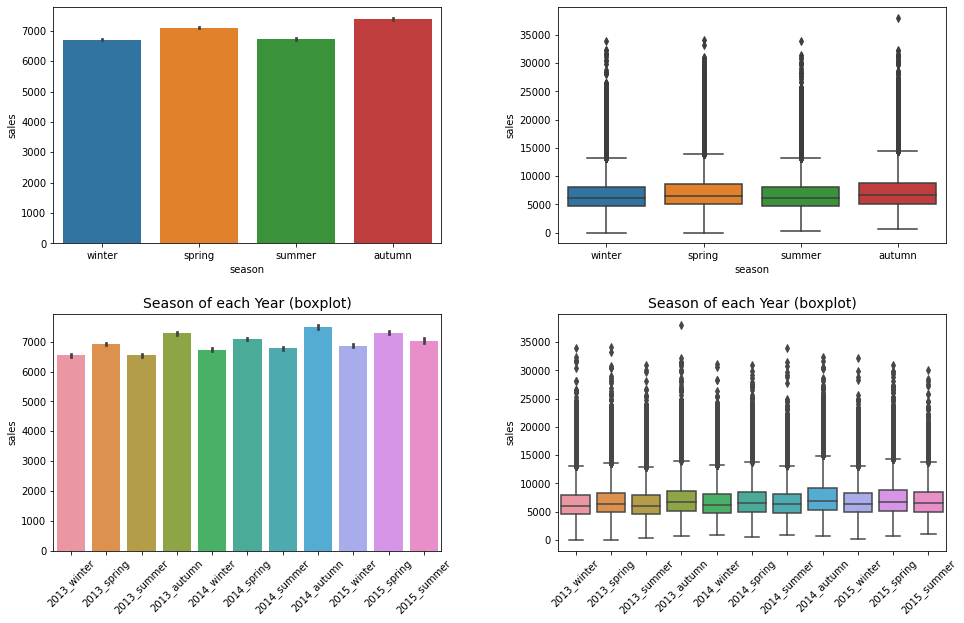

In [204]:
plt.figure(figsize=(16,10))
plt.subplots_adjust(wspace=0.3,hspace=0.3)

plt.subplot(2,2,1)
sns.barplot(x=dados['season'],y=dados['sales'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['season'],y=dados['sales'])


# Let's see if this happens every year
plt.subplot(2,2,3)
year_season = dados.apply(lambda x: str(x['year'])+'_'+str(x['season']), axis=1)
order = ['2013_winter', '2013_spring', '2013_summer', '2013_autumn','2014_winter', '2014_spring', '2014_summer', '2014_autumn','2015_winter','2015_spring', '2015_summer']
ax = sns.barplot(x=year_season,y=dados['sales'],order=order)
ax.set_title('Season of each Year (boxplot)',size=14)
plt.tick_params(axis='x',rotation=45)

plt.subplot(2,2,4)
ax = sns.boxplot(x=year_season,y=dados['sales'],order=order)
ax.set_title('Season of each Year (boxplot)',size=14)
plt.tick_params(axis='x',rotation=45)

plt.show()

The hypothesis is **FALSE**

Há mais vendas, em todos os anos, nos períodos de primavera e outono (Apenas é necessário lembrar que não temos registros do outono de 2015)

### H8: Se a loja tem competidor ela vende menos

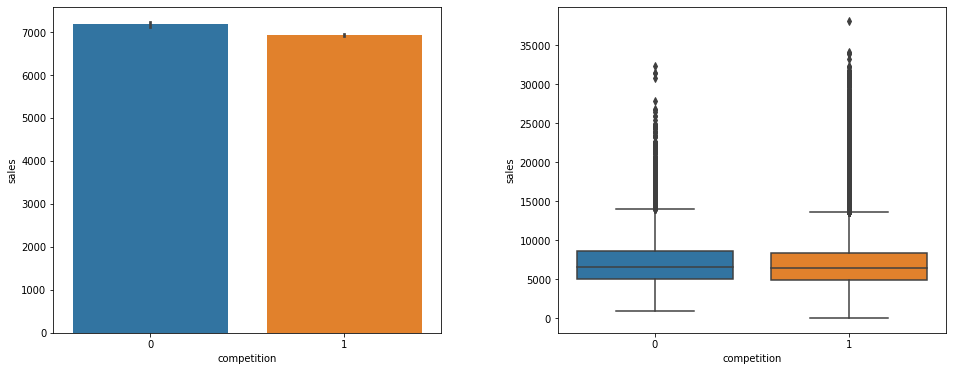

In [205]:
plt.figure(figsize=(16,6))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['competition'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['competition'],y=dados['sales'])

plt.show()

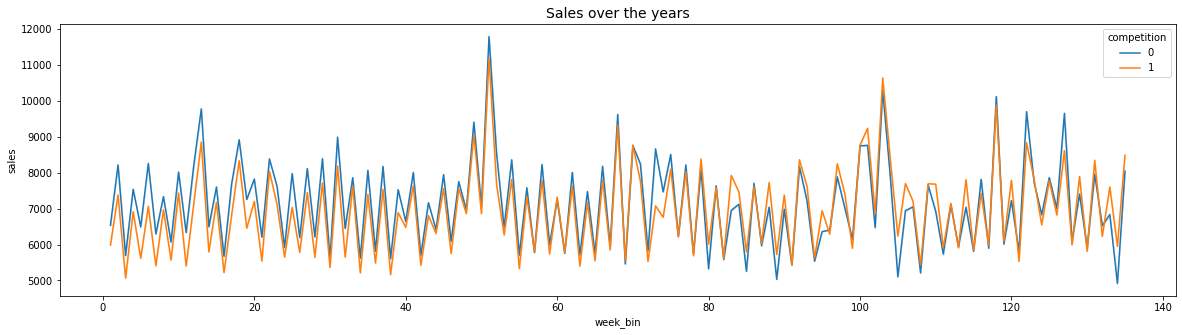

In [206]:
# let's see if this occurred all over the years

plt.figure(figsize=(20,5))
ax = sns.lineplot(dados['week_bin'],dados['sales'],hue=dados['competition'],ci=False)
ax.set_title('Sales over the years',size=14)
plt.show()

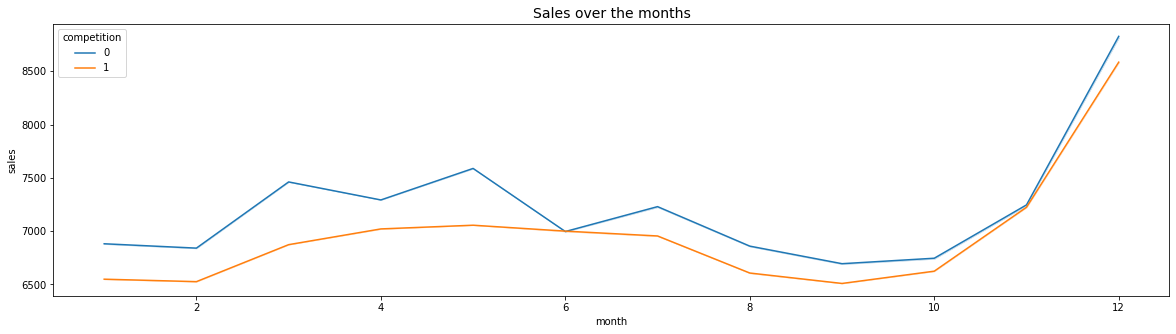

In [207]:
# let's see if this occurred all over the month

plt.figure(figsize=(20,5))
ax = sns.lineplot(dados['month'],dados['sales'],hue=dados['competition'],ci=False)
ax.set_title('Sales over the months',size=14)
plt.show()

In [208]:
# descriptive analysis
dados.groupby('competition').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
competition,,,,,,,,
0,14405.0,7175.756335,3184.335609,898.0,5036.0,6586.0,8620.0,32355.0
1,154569.0,6931.174272,3092.846876,0.0,4845.0,6345.0,8335.0,38025.0


The hypothesis is **TRUE**

Vemos uma diferença sutil nos gráficos observados, o que foi confirmado com a análise descritiva, mas ela existe, assim como esperávamos.

### H9: Quanto mais velha é a competição, menos a loja vende

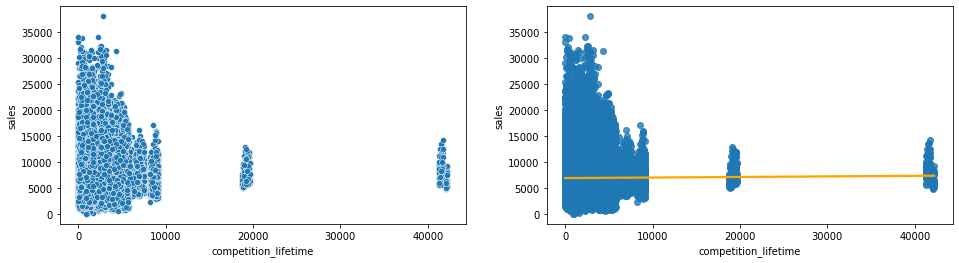

In [209]:
df_aux = dados[dados['competition']==1] # In this hypothesis I need to analyse stores that have competititors 

plt.figure(figsize=(16,4))


plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_lifetime'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_lifetime'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [210]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_lifetime','sales']))

Coeficiente de Correlação de Pearson: 0.006212351543071998


Acho que esses dois focos, em x = 20000 e 40000 são de duas lojas específicas que podem atrapalhar nossa análise, são claramente outliers.

In [211]:
# Finding how many stores are
print('Quantidade de lojas dos dois focos: {} stores'.format(dados[dados['competition_lifetime']>15000]['store'].unique().shape[0]))

Quantidade de lojas dos dois focos: 2 stores


São de fato duas lojas que estão atrapalhando, vamos retirá-las para vermos melhor a tendência no gráfico de dispersão.

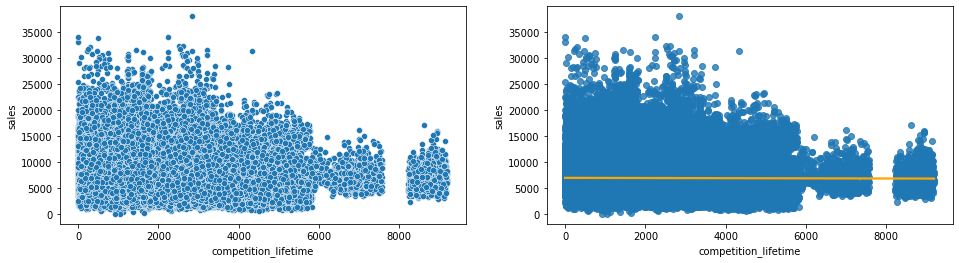

In [212]:
df_aux = df_aux[df_aux['competition_lifetime']<15000] # Removing these two stores

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_lifetime'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_lifetime'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [213]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_lifetime','sales']))

Coeficiente de Correlação de Pearson: -0.006579295455596741


Tendência quase nula, reta de regressão na horizontal! 

Logo, baseado nessas informações que temos: This hypothesis is **FALSE**

### H10 Quanto mais longe é o competidor, mais vende a loja

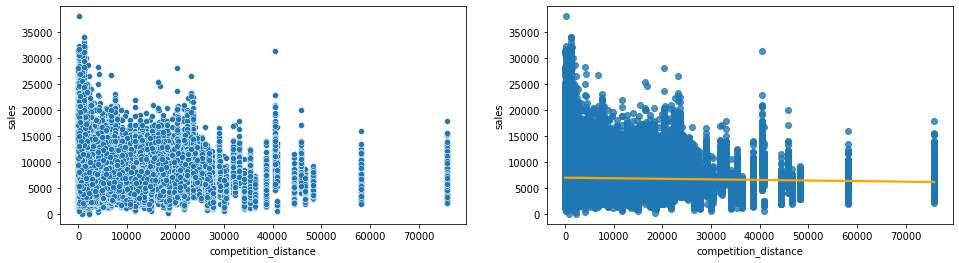

In [214]:
df_aux = dados[dados['competition']==1] # In this hypothesis I need to analyse stores that have competititors 

plt.figure(figsize=(16,4))


plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_distance'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_distance'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [215]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_distance','sales']))

Coeficiente de Correlação de Pearson: -0.02747174673606281


Temos dois focos em x > 50000 que acredito serem pouquíssimas lojas, ou seja, outliers que podem estar prejudicando a análise do comportamento geral

In [216]:
# Finding how many stores are
print('Quantidade de lojas dos dois focos: {} stores'.format(dados[dados['competition_distance']>50000]['store'].unique().shape[0]))

Quantidade de lojas dos dois focos: 5 stores


Era o que eu esperava, vamos retirá-las para vermos melhor a tendência no gráfico de dispersão.

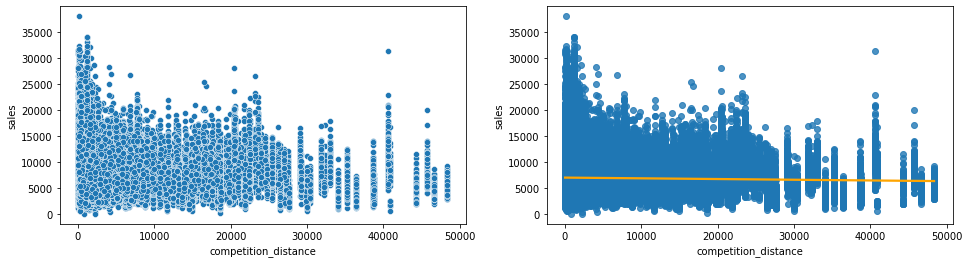

In [217]:
df_aux = df_aux[df_aux['competition_distance']<50000] # Removing these five stores

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['competition_distance'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['competition_distance'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [218]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['competition_distance','sales']))

Coeficiente de Correlação de Pearson: -0.03212144475282536


Tendência quase nula, reta de regressão na horizontal! 

Logo, baseado nessas informações que temos: This hypothesis is **FALSE**

### H11: Existem tipos de loja que vendem substancialmente mais

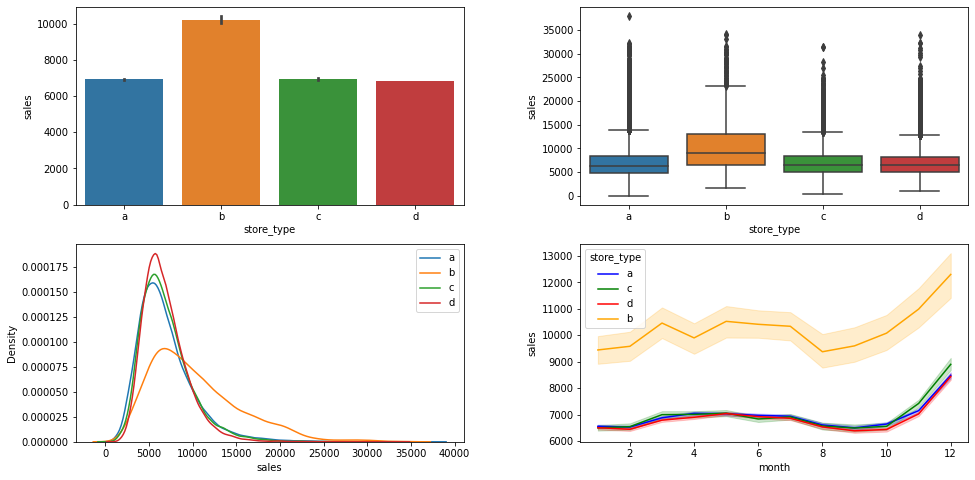

In [219]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,2,1)
sns.barplot(x=dados['store_type'],y=dados['sales'],order=['a','b','c','d'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['store_type'],y=dados['sales'],order=['a','b','c','d'])

plt.subplot(2,2,3)
sns.kdeplot(x=dados[dados['store_type']=='a']['sales'])
sns.kdeplot(x=dados[dados['store_type']=='b']['sales'])
sns.kdeplot(x=dados[dados['store_type']=='c']['sales'])
sns.kdeplot(x=dados[dados['store_type']=='d']['sales'])
plt.legend(['a','b','c','d'])

plt.subplot(2,2,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['store_type'],palette=['blue','green','red','orange'])

plt.show()

In [220]:
# descriptive analysis
dados.groupby(dados['store_type']).describe()['sales']

,count,mean,std,min,25%,50%,75%,max
store_type,,,,,,,,
a,91604.0,6913.937863,3268.183471,0.0,4690.75,6275.0,8390.00,38025.0
b,3148.0,10210.817662,5146.803060,1691.0,6389.50,9095.5,13117.75,34133.0
c,22542.0,6939.208810,2908.907195,316.0,4906.00,6415.0,8351.75,31448.0
d,51680.0,6826.621188,2559.318904,1007.0,5052.00,6399.0,8135.00,33966.0


Apesar de ter poucos records, é um número razoável e a diferença do tipo B para os outros é enorme em todos as análises! Além disso, se considerarmos um intervalo de confiança no lineplot para termos maior segurança na afirmação, vemos que ele não chega perto dos demais store_types, é muito maior.

Dessa forma, considero que: The hypothesis is **TRUE**

### H12: Quanto mais diversa é a loja, mais ela vende

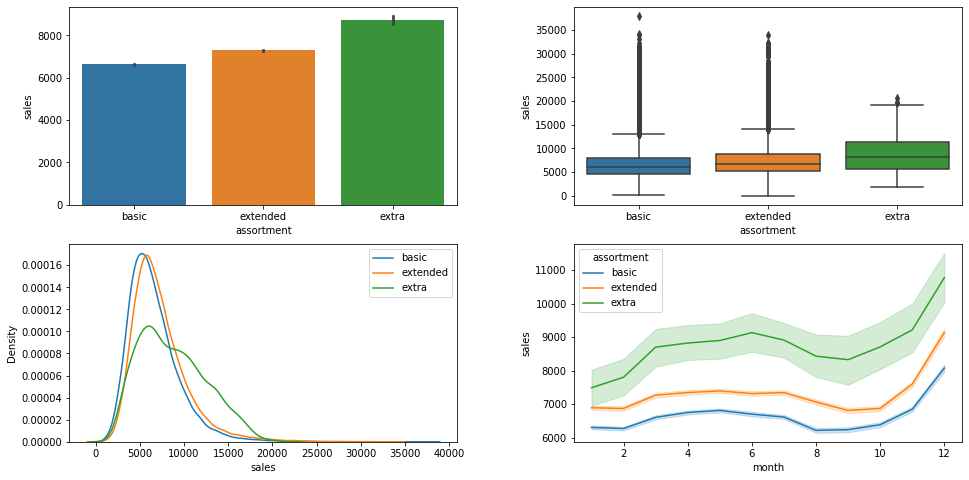

In [221]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,2,1)
sns.barplot(x=dados['assortment'],y=dados['sales'],order=['basic','extended','extra'])

plt.subplot(2,2,2)
sns.boxplot(x=dados['assortment'],y=dados['sales'],order=['basic','extended','extra'])

plt.subplot(2,2,3)
sns.kdeplot(x=dados[dados['assortment']=='basic']['sales'])
sns.kdeplot(x=dados[dados['assortment']=='extended']['sales'])
sns.kdeplot(x=dados[dados['assortment']=='extra']['sales'])
plt.legend(['basic','extended','extra'])

plt.subplot(2,2,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['assortment'])

plt.show()

In [222]:
# descriptive analysis
dados.groupby(dados['assortment']).describe()['sales']

,count,mean,std,min,25%,50%,75%,max
assortment,,,,,,,,
basic,88831.0,6622.689005,2980.009143,124.0,4601.0,6080.0,8006.00,38025.0
extended,78454.0,7286.939238,3171.518934,0.0,5163.0,6666.0,8699.75,33966.0
extra,1689.0,8716.298401,3749.503748,1869.0,5704.0,8245.0,11273.00,20557.0


This Hypothesis is **TRUE**

É visível uma correlação positiva na relação entre assortment e sales:

A extra desponta como a com maior volume de vendas, seguida pela extended e depois pela basic.

### H13: Quando tem promoção as lojas vendem mais

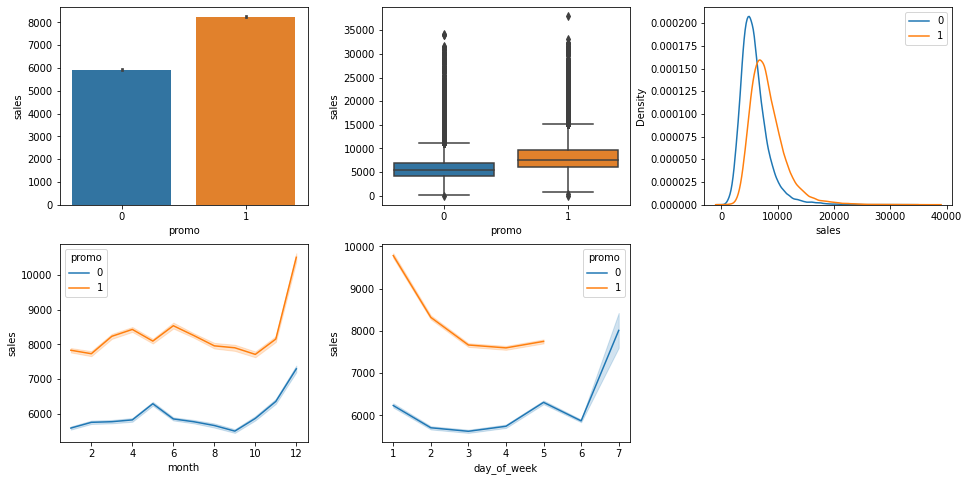

In [223]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,3,1)
sns.barplot(x=dados['promo'],y=dados['sales'])

plt.subplot(2,3,2)
sns.boxplot(x=dados['promo'],y=dados['sales'])

plt.subplot(2,3,3)
sns.kdeplot(x=dados[dados['promo']==0]['sales'])
sns.kdeplot(x=dados[dados['promo']==1]['sales'])
plt.legend(['0','1'])

plt.subplot(2,3,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['promo'])

plt.subplot(2,3,5)
sns.lineplot(x=dados['day_of_week'],y=dados['sales'],hue=dados['promo'])

plt.show()

In [224]:
# descriptive analysis
dados.groupby(dados['promo']).describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo,,,,,,,,
0,93827.0,5920.483741,2615.648155,0.0,4241.0,5462.0,6987.0,34133.0
1,75147.0,8239.985868,3178.057755,0.0,6083.0,7660.0,9706.0,38025.0


Promo certamente é a variável com maior impacto que analisamos até agora, a diferença nas sales é enorme em todas as análises que fizemos!

This hypothesis is **TRUE**

Mas há algo que me chamou muito a atenção: não existem promoções nos fins de semanas, e talvez explique parcialmente o porquê do fim de semana vender tão mal, como visto na Hipótese 3.

### H14: Quanto mais vezes se tem promoção em um período, menos eficaz ela fica

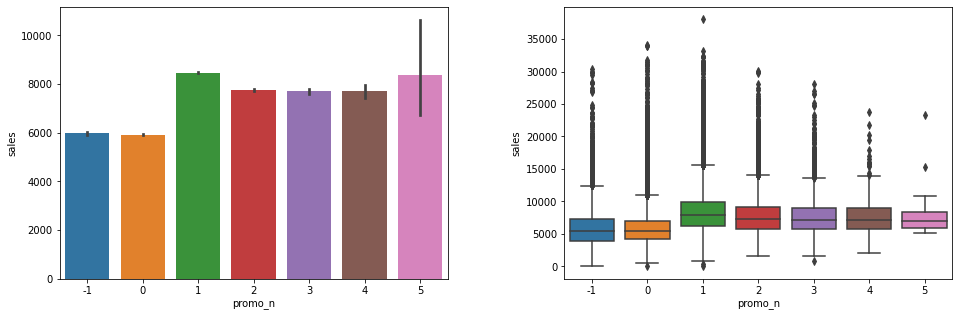

In [225]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['promo_n'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['promo_n'],y=dados['sales'])

plt.show()

In [243]:
# Descriptive Analysis
dados.groupby('promo_n').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo_n,,,,,,,,
-1,10351.0,5986.766110,3035.661229,124.0,3949.5,5505.0,7353.50,30329.0
0,83476.0,5912.264747,2558.667843,0.0,4269.0,5456.0,6943.00,34133.0
1,51138.0,8470.216551,3287.099119,0.0,6234.0,7883.0,9980.00,38025.0
2,19400.0,7760.255000,2875.738355,1534.0,5820.0,7254.0,9102.00,30074.0
3,4168.0,7702.383877,2843.762068,816.0,5776.0,7206.5,8935.75,28127.0
4,423.0,7699.654846,2870.500659,2090.0,5761.0,7213.0,9058.00,23842.0
5,18.0,8380.388889,4441.646053,5221.0,5866.5,7057.0,8416.75,23244.0


This hypothesis is **FALSE**

A gente claramente vê que os dias entre promoções são iguais àqueles de semanas sem promoção, não há uma queda nas vendas.

O que vemos é uma queda nas vendas na segunda promoção da semana, sendo a primeira a mais efetiva, mas o volume de vendas não decai mais, se torna relativamente constante.

### H15: Quanto mais vezes se tem promoção em um período, mais a loja vende

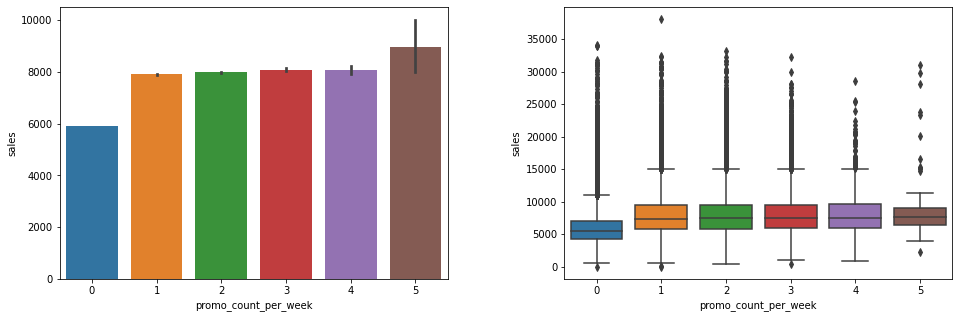

In [241]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['promo_count_per_week'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['promo_count_per_week'],y=dados['sales'])

plt.show()

In [242]:
# Descriptive Analysis
dados.groupby('promo_count_per_week').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo_count_per_week,,,,,,,,
0,83476.0,5912.264747,2558.667843,0.0,4269.00,5456.0,6943.00,34133.0
1,38187.0,7906.203263,3316.189654,0.0,5717.00,7384.0,9441.00,38025.0
2,33526.0,7985.668615,3172.170792,316.0,5843.00,7468.0,9532.75,33151.0
3,11986.0,8087.084682,3216.188355,416.0,5912.25,7504.0,9542.00,32263.0
4,1705.0,8072.955425,3094.895662,816.0,5970.00,7528.0,9599.00,28564.0
5,94.0,8950.404255,5216.406181,2185.0,6341.25,7592.0,9019.50,30983.0


This hypothesis is **TRUE**

Mas não é uma diferença muito grande, mas podemos vê-la mais claramente na análise descritiva.

### H16: Se a loja acatar a promo2 ela vende mais

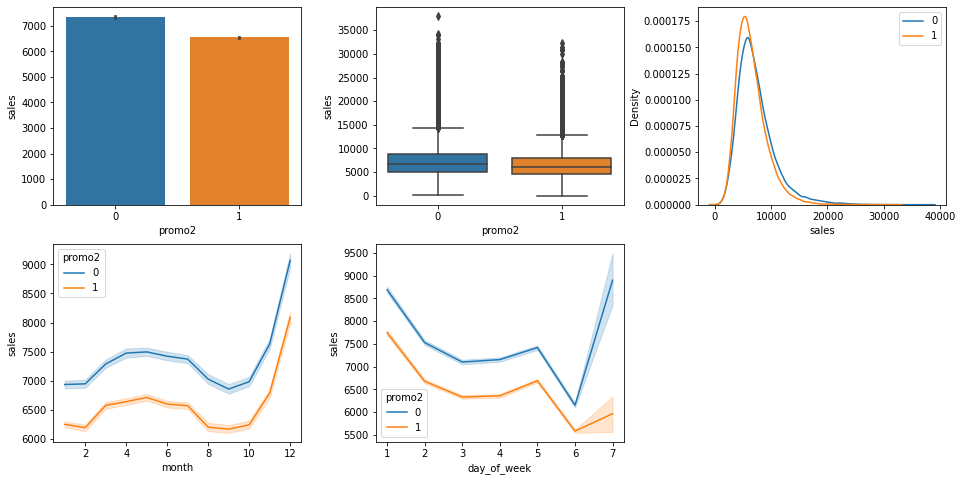

In [245]:
plt.figure(figsize=(16,8))
plt.subplots_adjust(wspace=0.3)

plt.subplot(2,3,1)
sns.barplot(x=dados['promo2'],y=dados['sales'])

plt.subplot(2,3,2)
sns.boxplot(x=dados['promo2'],y=dados['sales'])

plt.subplot(2,3,3)
sns.kdeplot(x=dados[dados['promo2']==0]['sales'])
sns.kdeplot(x=dados[dados['promo2']==1]['sales'])
plt.legend(['0','1'])

plt.subplot(2,3,4)
sns.lineplot(x=dados['month'],y=dados['sales'],hue=dados['promo2'])

plt.subplot(2,3,5)
sns.lineplot(x=dados['day_of_week'],y=dados['sales'],hue=dados['promo2'])

plt.show()

In [246]:
# Descriptive Analysis
dados.groupby('promo2').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo2,,,,,,,,
0,84787.0,7345.566231,3393.205347,124.0,5085.0,6682.0,8821.0,38025.0
1,84187.0,6555.678691,2719.968175,0.0,4663.0,6073.0,7909.0,32355.0


This hipothesis is **FALSE**

Certamente isso é um grande insight para a empresa, a promo2 na verdade diminui o volume de vendas da loja!

### H17: Existem períodos onde a promo2 é mais eficaz em relação às vendas

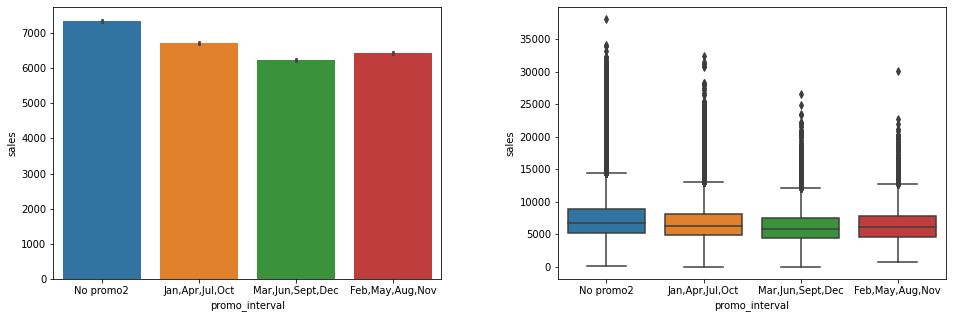

In [248]:
plt.figure(figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

plt.subplot(1,2,1)
sns.barplot(x=dados['promo_interval'],y=dados['sales'])

plt.subplot(1,2,2)
sns.boxplot(x=dados['promo_interval'],y=dados['sales'])

plt.show()

In [250]:
# Descriptive Analysis
dados.groupby('promo_interval').describe()['sales']

,count,mean,std,min,25%,50%,75%,max
promo_interval,,,,,,,,
"Feb,May,Aug,Nov",19540.0,6426.706244,2571.915127,625.0,4572.0,6015.5,7831.25,30038.0
"Jan,Apr,Jul,Oct",48582.0,6714.960664,2804.696698,0.0,4791.0,6207.0,8078.75,32355.0
"Mar,Jun,Sept,Dec",16065.0,6230.866044,2594.998046,0.0,4430.0,5758.0,7500.00,26485.0
No promo2,84787.0,7345.566231,3393.205347,124.0,5085.0,6682.0,8821.00,38025.0


This hypothesis is **TRUE**

Há claras mudanças no volume de vendas, as quais podem ser facilmente percebidas no gráfico.

### H18: Quanto mais antiga a promo2, menos a loja vende

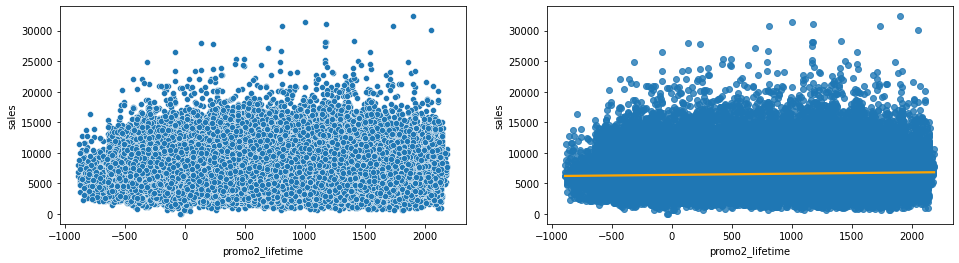

In [259]:
df_aux = dados[dados['promo2']==1] # In this hypothesis I need to analyse stores that have competititors 

plt.figure(figsize=(16,4))


plt.subplot(1,2,1)
sns.scatterplot(x=df_aux['promo2_lifetime'],y=df_aux['sales'])

plt.subplot(1,2,2)
sns.regplot(x=df_aux['promo2_lifetime'],y=df_aux['sales'],line_kws={"color": "orange"})

plt.show()

In [260]:
# corr for this analysis
print('Coeficiente de Correlação de Pearson: {}'.format(df_aux.corr('pearson').loc['promo2_lifetime','sales']))

Coeficiente de Correlação de Pearson: 0.04732422259554335


This hypothesis is **True**

A relação é bem fraca, mas ainda existente, ela diz que quanto mais velha, mais se vende e quanto mais nova menos se vende.

### Overall

In [25]:
table = [['Hypothesis','Feature','Result','Relevance'],
        ['1','Day','True','High'],
        ['2','Year','True','High'],
        ['3','Day of Week','False','High'],
        ['4','State Holiday/Public Holiday','True/False','High/Low'],
        ['5','Semester','True','Low'],
        ['6','Quarter','False','Medium'],
        ['7','Season','False','Medium'],
        ['8','Competition','True','Low'],
        ['9','Competition Distance','False','Low'],
        ['10','Competition Lifetime','False','Low'],
        ['11','Store Type','True','High'],
        ['12','Assortment','True','High'],
        ['13','Promo','True','High'],
        ['14','Promo_n','True','Medium'],
        ['15','Promo Count Per Week','True','Low'],
        ['16','Promo2','False','Medium'],
        ['17','Promo Interval','True','Medium'],
        ['18','Promo2 Lifetime','True','Low']]
print(tabulate(table,headers='firstrow'))

  Hypothesis  Feature                       Result      Relevance
------------  ----------------------------  ----------  -----------
           1  Day                           True        High
           2  Year                          True        High
           3  Day of Week                   False       High
           4  State Holiday/Public Holiday  True/False  High/Low
           5  Semester                      True        Low
           6  Quarter                       False       Medium
           7  Season                        False       Medium
           8  Competition                   True        Low
           9  Competition Distance          False       Low
          10  Competition Lifetime          False       Low
          11  Store Type                    True        High
          12  Assortment                    True        High
          13  Promo                         True        High
          14  Promo_n                       True        Medium
      

## 2.5 Multivariate Analysis

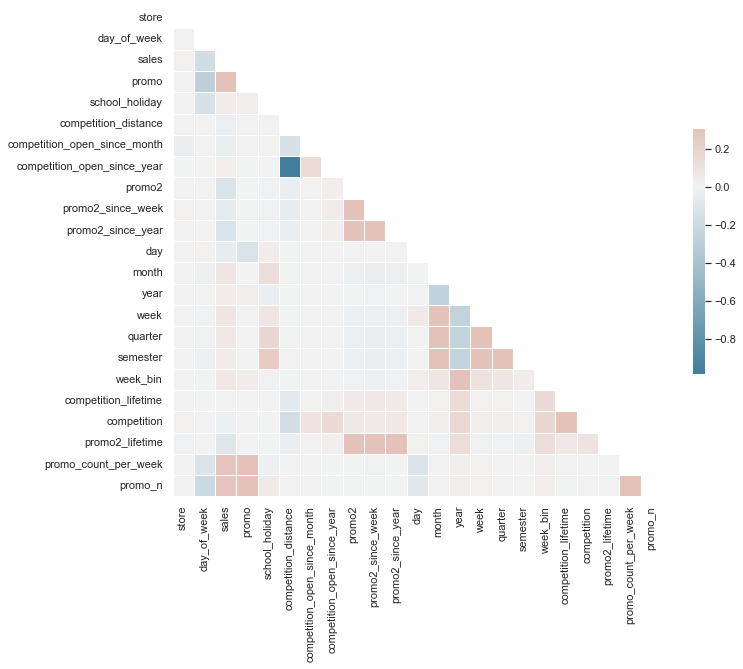

In [268]:
# Using seaborn diagonal correlation matrix: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

sns.set_theme(style="white")

# Compute the correlation matrix
corr = dados.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# 3.0 Data Preprocessing

## 3.1 Normalization

In [411]:
# Apparently there's no normal distributed features

## 3.2 Encoding

In [412]:
## One Hot Encoding (state_holiday)
dados['easter'] = dados['state_holiday'].apply(lambda x: 1 if x=='Easter holiday' else 0)
dados['public_holiday'] = dados['state_holiday'].apply(lambda x: 1 if x=='public holiday' else 0)
dados['christmas'] = dados['state_holiday'].apply(lambda x: 1 if x=='Christmas' else 0)
dados.drop('state_holiday',1,inplace=True)

## Label Encoding (store_type)
dados['store_type'] = LabelEncoder().fit_transform(dados[['store_type']])

## Ordinal Encoding (assortment, season)
dados['assortment'] = dados['assortment'].map({'basic':0,'extended':1,'extra':2})
dados['season'] = dados['season'].map({'winter':1,'spring':2,'summer':3,'autumn':4})

## Target Encoding (promo_interval)
dados['promo_interval'] = TargetEncoder().fit_transform(dados['promo_interval'],y=dados['sales'])

## Cyclic Encoding (day_of_week, competition_open_since_month, promo2_since_week, day, month, week, quarter, semester, season)
dados['day_of_week_sin'] = dados['day_of_week'].apply(lambda x: np.sin(2*np.pi*x/7))
dados['day_of_week_cos'] = dados['day_of_week'].apply(lambda x: np.cos(2*np.pi*x/7))
dados.drop('day_of_week',1,inplace=True)

dados['competition_open_since_month_sin'] = dados['competition_open_since_month'].apply(lambda x: np.sin(2*np.pi*x/12))
dados['competition_open_since_month_cos'] = dados['competition_open_since_month'].apply(lambda x: np.cos(2*np.pi*x/12))
dados.drop('competition_open_since_month',1,inplace=True)

dados['promo2_since_week_sin'] = dados['promo2_since_week'].apply(lambda x: np.sin(2*np.pi*x/52))
dados['promo2_since_week_cos'] = dados['promo2_since_week'].apply(lambda x: np.cos(2*np.pi*x/52))
dados.drop('promo2_since_week',1,inplace=True)

dados['day_sin'] = dados['day'].apply(lambda x: np.sin(2*np.pi*x/30))
dados['day_cos'] = dados['day'].apply(lambda x: np.cos(2*np.pi*x/30))
dados.drop('day',1,inplace=True)

dados['month_sin'] = dados['month'].apply(lambda x: np.sin(2*np.pi*x/12))
dados['month_cos'] = dados['month'].apply(lambda x: np.cos(2*np.pi*x/12))
dados.drop('month',1,inplace=True)

dados['week_sin'] = dados['week'].apply(lambda x: np.sin(2*np.pi*x/52))
dados['week_cos'] = dados['week'].apply(lambda x: np.cos(2*np.pi*x/52))
dados.drop('week',1,inplace=True)

dados['quarter_sin'] = dados['quarter'].apply(lambda x: np.sin(2*np.pi*x/4))
dados['quarter_cos'] = dados['quarter'].apply(lambda x: np.cos(2*np.pi*x/4))
dados.drop('quarter',1,inplace=True)

dados['semester_sin'] = dados['semester'].apply(lambda x: np.sin(2*np.pi*x/2))
dados['semester_cos'] = dados['semester'].apply(lambda x: np.cos(2*np.pi*x/2))
dados.drop('semester',1,inplace=True)

dados['season_sin'] = dados['season'].apply(lambda x: np.sin(2*np.pi*x/4))
dados['season_cos'] = dados['season'].apply(lambda x: np.cos(2*np.pi*x/4))
dados.drop('season',1,inplace=True)

## 3.3 Rescaling

In [413]:
## Min Max Scaler (week_bin, promo_count_per_week, promo_n, year, store_type, assortment, promo_interval, day_of_week_sin/cos, competition_open_since_month_sin/cos, promo2_since_week_sin/cos, day_sin/cos, month_sin/cos, week_sin/cos, quarter_sin/cos, semester_sin/cos, season_sin/cos)

dados['week_bin'] = MinMaxScaler().fit_transform(dados[['week_bin']])

dados['promo_count_per_week'] = MinMaxScaler().fit_transform(dados[['promo_count_per_week']])

dados['promo_n'] = MinMaxScaler().fit_transform(dados[['promo_n']])

dados['year'] = MinMaxScaler().fit_transform(dados[['year']])

dados['store_type'] = MinMaxScaler().fit_transform(dados[['store_type']])

dados['assortment'] = MinMaxScaler().fit_transform(dados[['assortment']])

dados['promo_interval'] = MinMaxScaler().fit_transform(dados[['promo_interval']])

dados['day_of_week_sin'] = MinMaxScaler().fit_transform(dados[['day_of_week_sin']])
dados['day_of_week_cos'] = MinMaxScaler().fit_transform(dados[['day_of_week_cos']])

dados['competition_open_since_month_sin'] = MinMaxScaler().fit_transform(dados[['competition_open_since_month_sin']])
dados['competition_open_since_month_cos'] = MinMaxScaler().fit_transform(dados[['competition_open_since_month_cos']])

dados['promo2_since_week_sin'] = MinMaxScaler().fit_transform(dados[['promo2_since_week_sin']])
dados['promo2_since_week_cos'] = MinMaxScaler().fit_transform(dados[['promo2_since_week_cos']])

dados['day_sin'] = MinMaxScaler().fit_transform(dados[['day_sin']])
dados['day_cos'] = MinMaxScaler().fit_transform(dados[['day_cos']])

dados['month_sin'] = MinMaxScaler().fit_transform(dados[['month_sin']])
dados['month_cos'] = MinMaxScaler().fit_transform(dados[['month_cos']])

dados['week_sin'] = MinMaxScaler().fit_transform(dados[['week_sin']])
dados['week_cos'] = MinMaxScaler().fit_transform(dados[['week_cos']])

dados['quarter_sin'] = MinMaxScaler().fit_transform(dados[['quarter_sin']])
dados['quarter_cos'] = MinMaxScaler().fit_transform(dados[['quarter_cos']])

dados['semester_sin'] = MinMaxScaler().fit_transform(dados[['semester_sin']])
dados['semester_cos'] = MinMaxScaler().fit_transform(dados[['semester_cos']])

dados['season_sin'] = MinMaxScaler().fit_transform(dados[['season_sin']])
dados['season_cos'] = MinMaxScaler().fit_transform(dados[['season_cos']])



## Robust Scaler (competition_distance, competition_open_since_year, promo2_since_year, competition_lifetime, promo2_lifetime, year)

dados['competition_distance'] = RobustScaler().fit_transform(dados[['competition_distance']])
dados['competition_open_since_year'] = RobustScaler().fit_transform(dados[['competition_open_since_year']])
dados['promo2_since_year'] = RobustScaler().fit_transform(dados[['promo2_since_year']])
dados['competition_lifetime'] = RobustScaler().fit_transform(dados[['competition_lifetime']])
dados['promo2_lifetime'] = RobustScaler().fit_transform(dados[['promo2_lifetime']])

## 3.4 Target Transformation

In [414]:
## Log Transformation (sales)
dados['sales'] = np.log1p(dados['sales'])